# Problem 4.3 – Variational Autoencoder (VAE)

## 4.3.1 Conceptual introduction to Variational Autoencoders (VAEs)

A Variational Autoencoder (VAE) is a generative model that learns a probabilistic latent representation of data.
It consists of:
- an encoder $q_\phi(\mathbf{z}\mid\mathbf{x})$ that maps data $\mathbf{x}$ to a distribution over latent variables $\mathbf{z}$,
- a decoder $p_\theta(\mathbf{x}\mid\mathbf{z})$ that maps latent variables back to a distribution over data.

### Notation and assumptions
- Prior on latent variables: $p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$.
- Variational posterior (encoder): $q_\phi(\mathbf{z}\mid\mathbf{x}) = \mathcal{N}\!\big(\boldsymbol\mu_\phi(\mathbf{x}), \mathrm{diag}(\boldsymbol\sigma^2_\phi(\mathbf{x}))\big)$.
  In practice we predict $\boldsymbol\mu$ and $\log\boldsymbol\sigma^2$ (aka `logvar`) for numerical stability.
- Likelihood (decoder): $p_\theta(\mathbf{x}\mid\mathbf{z})$.
  - If we use mean squared error (MSE) as reconstruction loss, this corresponds to a Gaussian likelihood with fixed variance: $p_\theta(\mathbf{x}\mid\mathbf{z}) = \mathcal{N}(\hat{\mathbf{x}}_\theta(\mathbf{z}), \beta \mathbf{I})$ (for some $\beta>0$).
  - If we use binary cross-entropy (BCE) on $[0,1]$ images, this corresponds to a Bernoulli likelihood with mean $\hat{\mathbf{x}}_\theta(\mathbf{z})$.

### Objective: ELBO
Maximizing the log marginal likelihood $\log p_\theta(\mathbf{x})$ directly is intractable,
so we maximize the Evidence Lower BOund (ELBO):
$$
\mathcal{L}_{\text{ELBO}}(\theta,\phi;\mathbf{x})
= \mathbb{E}_{q_\phi(\mathbf{z}\mid\mathbf{x})}\big[\log p_\theta(\mathbf{x}\mid\mathbf{z})\big]
- \mathrm{KL}\!\big(q_\phi(\mathbf{z}\mid\mathbf{x}) \,\|\, p(\mathbf{z})\big).
$$
Training conventionally minimizes the negative ELBO:
$$
\mathcal{L}_{\text{VAE}}(\mathbf{x})
= -\,\mathbb{E}_{q_\phi(\mathbf{z}\mid\mathbf{x})}\big[\log p_\theta(\mathbf{x}\mid\mathbf{z})\big]
+ \mathrm{KL}\!\big(q_\phi(\mathbf{z}\mid\mathbf{x}) \,\|\, p(\mathbf{z})\big).
$$

For Gaussian decoder with fixed variance $\beta\mathbf{I}$, the first term reduces (up to a constant scale) to the per-pixel MSE between $\mathbf{x}$ and $\hat{\mathbf{x}}=\hat{\mathbf{x}}_\theta(\mathbf{z})$:
$$
-\,\mathbb{E}_{q}\big[\log p_\theta(\mathbf{x}\mid\mathbf{z})\big]
\propto \frac{1}{2\beta}\,\|\mathbf{x}-\hat{\mathbf{x}}\|_2^2.
$$
In practice we implement it as an MSE over pixels/channels, reduced to a scalar per batch.

### Closed-form KL for diagonal Gaussians
With $q_\phi(\mathbf{z}\mid\mathbf{x})=\mathcal{N}(\boldsymbol\mu, \mathrm{diag}(\boldsymbol\sigma^2))$ and $p(\mathbf{z})=\mathcal{N}(\mathbf{0},\mathbf{I})$:
$$
\mathrm{KL}\!\big(q \,\|\, p\big)
= \frac{1}{2}\sum_{i=1}^d \big(\mu_i^2 + \sigma_i^2 - \log \sigma_i^2 - 1\big).
$$
Using `logvar = \log \sigma^2`, one computes $\sigma^2 = \exp(\text{logvar})$ and uses the same formula.

### Reparameterization trick
To backpropagate through sampling from $q_\phi(\mathbf{z}\mid\mathbf{x})$, we write
$$
\mathbf{z} = \boldsymbol\mu + \boldsymbol\sigma \odot \boldsymbol\epsilon,
\quad \boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0},\mathbf{I}),
\quad \boldsymbol\sigma = \exp\!\big(\tfrac{1}{2}\,\text{logvar}\big).
$$
This makes sampling a deterministic function of $(\boldsymbol\mu,\text{logvar},\boldsymbol\epsilon)$, enabling gradient flow.

### Practical implementation notes (for the next steps)
- Encoder outputs: `mu`, `logvar`; use a `Sampling` layer to produce `z`.
- Decoder outputs: reconstruction $\hat{\mathbf{x}}$ in $[0,1]$ via a final `sigmoid` when inputs are normalized to $[0,1]$.
- Loss per batch:
  - Reconstruction: sum over pixels/channels per sample, then mean over batch (consistent scalar).
  - KL: sum over latent dims per sample, then mean over batch.
  - Total: `loss = recon_loss + kl_loss` (matching the exercise statement).
- Architectures for 28×28 images:
  - Encoder: Conv2D blocks with strides 2 to reduce to 7×7, then Dense to latent parameters.
  - Decoder: Dense to 7×7×C, then Conv2DTranspose with strides 2 to upsample back to 28×28.
- 2D latent ($d=2$) enables direct scatter plots and grid sampling visualizations.
- Uncertainty maps: multiple stochastic decodes for the same input yield per-pixel variance heatmaps.

### What to remember
- VAE optimizes a trade-off: accurate reconstructions vs. latent regularity (KL toward a standard normal).
- Using MSE corresponds to a Gaussian decoder; BCE corresponds to a Bernoulli decoder.
- Reparameterization trick is the key to make stochastic sampling differentiable.
- For diagonal Gaussians, the KL term is analytic and cheap to compute.


---

## 4.3.2 Fashion-MNIST: load, normalize, and visualize one sample per class

What we will do:
- Download Fashion-MNIST (60k train, 10k test), grayscale 28×28 images.
- Normalize to [0,1] and add a channel dimension -> shape (N, 28, 28, 1).
- Plot one randomly selected sample for each of the 10 classes.
- Optionally restrict training to the first 10,000 samples for speed (as allowed by the exercise).

Why:
- Normalization stabilizes optimization for subsequent model training.
- The channel dimension is required by Conv2D layers.
- Per-class samples help us visually inspect the dataset.

In [1]:
pip install tensorflow-macos tensorflow-metal


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Imports and basic setup for this section
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns





In [2]:
# Reproducibility (subject to GPU/cuDNN determinism limits)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Plot style
sns.set(context="notebook", style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (5.5, 5.0)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11

In [3]:
# Load Fashion-MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize to [0,1] and add channel dimension
x_train = (x_train.astype("float32") / 255.0)[..., None]  # (N, 28, 28, 1)
x_test  = (x_test.astype("float32")  / 255.0)[..., None]

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print("Train:", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

# Optionally limit to first 10k training samples for speed
USE_FIRST_10K = False  # set to False for the full 60k
if USE_FIRST_10K:
    x_train = x_train[:10000]
    y_train = y_train[:10000]
    print("Using subset of training data:", x_train.shape, y_train.shape)

Train: (60000, 28, 28, 1) (60000,)
Test:  (10000, 28, 28, 1) (10000,)


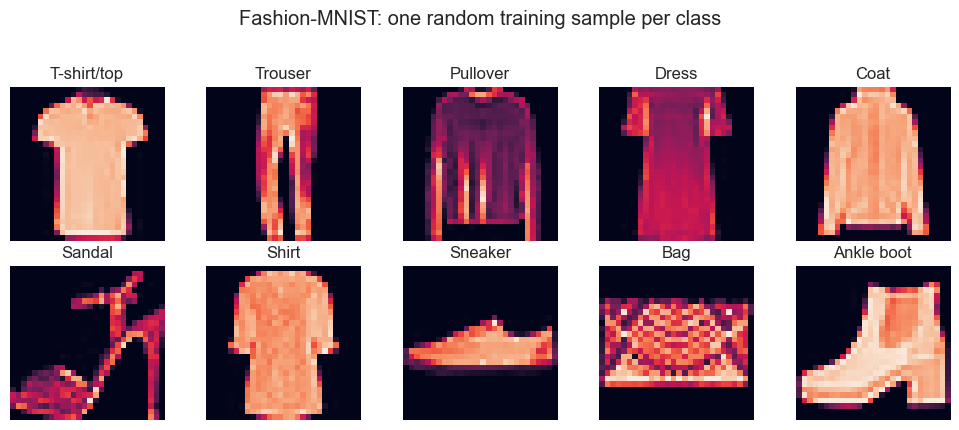

In [4]:
# Plot one random sample per class from the (possibly reduced) training set
rng = np.random.default_rng(SEED)
fig, axes = plt.subplots(2, 5, figsize=(10, 4.2))
picked_indices = []

for c in range(10):
    indices = np.where(y_train == c)[0]
    idx = rng.choice(indices)
    picked_indices.append(idx)

for ax, idx, c in zip(axes.ravel(), picked_indices, range(10)):
    ax.imshow(x_train[idx].squeeze(), vmin=0, vmax=1)
    ax.set_title(class_names[c])
    ax.axis("off")

fig.suptitle("Fashion-MNIST: one random training sample per class", y=1.02)
plt.tight_layout()
plt.show()

---

## 4.3.3 Implement VAE loss: MSE reconstruction + KL divergence

We implement three small, composable functions:

- `reconstruction_loss_mse(x, x_hat)`: per-pixel squared error, summed over spatial/channel dims per sample, then averaged over the batch to return a scalar.
- `kl_loss_diag_gaussian(mu, log_var)`: closed-form KL for a diagonal Gaussian posterior against a standard normal prior, summed over latent dims per sample, then averaged over the batch to return a scalar.
- `vae_total_loss(x, x_hat, mu, log_var)`: total VAE loss as the sum of reconstruction and KL losses (scalar).

In [6]:

def reconstruction_loss_mse(x: tf.Tensor, x_hat: tf.Tensor) -> tf.Tensor:
    """
    Mean squared reconstruction error.
    Reduction: sum over (H, W, C) per sample, then mean over batch -> scalar.
    """
    per_pixel = tf.math.squared_difference(x, x_hat)
    per_sample = tf.reduce_sum(per_pixel, axis=[1, 2, 3])
    return tf.reduce_mean(per_sample)

def kl_loss_diag_gaussian(mu: tf.Tensor, log_var: tf.Tensor) -> tf.Tensor:
    """
    Closed-form KL(q || p) with q = N(mu, diag(exp(log_var))) and p = N(0, I).
    Reduction: sum over latent dims per sample, then mean over batch -> scalar.
    """
    # sigma^2 = exp(log_var)
    kl_per_sample = 0.5 * tf.reduce_sum(
        tf.square(mu) + tf.exp(log_var) - log_var - 1.0, axis=1
    )
    return tf.reduce_mean(kl_per_sample)

def vae_total_loss(x: tf.Tensor, x_hat: tf.Tensor, mu: tf.Tensor, log_var: tf.Tensor) -> tf.Tensor:
    """
    Total VAE loss: reconstruction (MSE) + KL. Returns a scalar.
    """
    recon = reconstruction_loss_mse(x, x_hat)
    kl = kl_loss_diag_gaussian(mu, log_var)
    return recon + kl

---
## 4.3.4 VAE with latent size D_h = 2, training, and reconstructions

#### Model Introduction
In this section, we implement a **Convolutional Variational Autoencoder (VAE)** designed to compress Fashion-MNIST images into a 2-dimensional latent space ($D_h=2$).

**Architecture Choices:**
* **Encoder:** Uses `Conv2D` layers with `stride=2` for downsampling, followed by a `Dense` bottleneck layer. This structure helps capture spatial hierarchies and shapes (edges, textures) better than fully dense networks.
* **Latent Space:** We project the input into a 2D probabilistic space using the reparameterization trick (`Sampling` layer).
* **Decoder:** Mirrors the encoder using `Conv2DTranspose` layers to upsample the latent vector back to the original 28x28 resolution.
* **Loss Function:** Strictly adhering to the assignment requirements, we use **Mean Squared Error (MSE)** for the reconstruction loss.
    * *Crucial Implementation Detail:* To avoid **Posterior Collapse** (where the model ignores the input and generates a generic average blur), we calculate the MSE by **summing** over all pixels (`tf.reduce_sum`) rather than averaging. This scales the reconstruction signal appropriately against the KL Divergence term, ensuring the model prioritizes shape fidelity.

In [7]:
from tensorflow.keras import layers

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Sampling Layer (Standard Reparameterization Trick) ---
class Sampling(layers.Layer):
    """
    Uses (z_mean, z_log_var) to sample z, the vector encoding the input image.
    This allows backpropagation through the stochastic process.
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- 2. Encoder Architecture ---
def build_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    
    # Convolutional layers with stride 2 for downsampling (28 -> 14 -> 7)
    # Using Conv2D is better for capturing spatial features (shapes) than Dense layers
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    
    x = layers.Flatten()(x)
    
    # Dense bottleneck to mix spatial features before latent projection
    x = layers.Dense(16, activation="relu")(x)
    
    # Latent space output: mean and log-variance
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    
    # Sampling z using the reparameterization trick
    z = Sampling()([z_mean, z_log_var])
    
    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --- 3. Decoder Architecture ---
def build_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    
    # Expand latent vector to match the shape before flattening (7*7*64)
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    
    # Transposed convolutions with stride 2 for upsampling (7 -> 14 -> 28)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    
    # Output layer: Sigmoid activation to map outputs to [0, 1] pixel range
    # This matches the normalized input data
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

# --- 4. VAE Class with Custom Train Step ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta  # Weight for KL Divergence loss (Hyperparameter)
        
        # Metrics trackers
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # --- 1. Reconstruction Loss (MSE) ---
            # CRITICAL FIX: We SUM the MSE over spatial dimensions (axes 1, 2).
            # Standard 'reduce_mean' over pixels results in a very small loss value (e.g., 0.04),
            # which gets overwhelmed by the KL Divergence loss (e.g., 5.0).
            # Summing scales the reconstruction loss up (e.g., ~30.0), balancing the optimization.
            recon_loss = tf.reduce_sum(
                tf.keras.losses.mse(data, reconstruction), axis=(1, 2)
            )
            recon_loss = tf.reduce_mean(recon_loss) # Average over batch
            
            # --- 2. KL Divergence Loss (Analytical) ---
            # Measures difference between learned latent distribution and standard normal distribution
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_sum(kl_loss, axis=1) # Sum over latent dimensions
            kl_loss = tf.reduce_mean(kl_loss)        # Average over batch
            
            # Total Loss
            total_loss = recon_loss + (self.beta * kl_loss)

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }





2025-11-24 10:53:30.309009: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-24 10:53:30.309179: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-24 10:53:30.309193: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-24 10:53:30.309430: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-24 10:53:30.309449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2025-11-24 10:53:31.103079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - kl_loss: 3.5212 - loss: 52.2379 - recon_loss: 48.7168
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - kl_loss: 4.5147 - loss: 34.9971 - recon_loss: 30.4824
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - kl_loss: 4.4371 - loss: 34.0247 - recon_loss: 29.5876
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - kl_loss: 4.3898 - loss: 33.6362 - recon_loss: 29.2463
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - kl_loss: 4.3564 - loss: 33.4078 - recon_loss: 29.0514
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - kl_loss: 4.3329 - loss: 33.2829 - recon_loss: 28.9499
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - kl_loss: 4.3148 - loss: 33.1877 - recon_loss: 28.8729
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - kl_loss: 4.3037 - loss: 33.0999 - recon_loss: 28.7962
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - kl_loss: 4.2965 - loss: 33.0580 - recon_loss: 28.7614
Epoch 10/30
469/469 ━

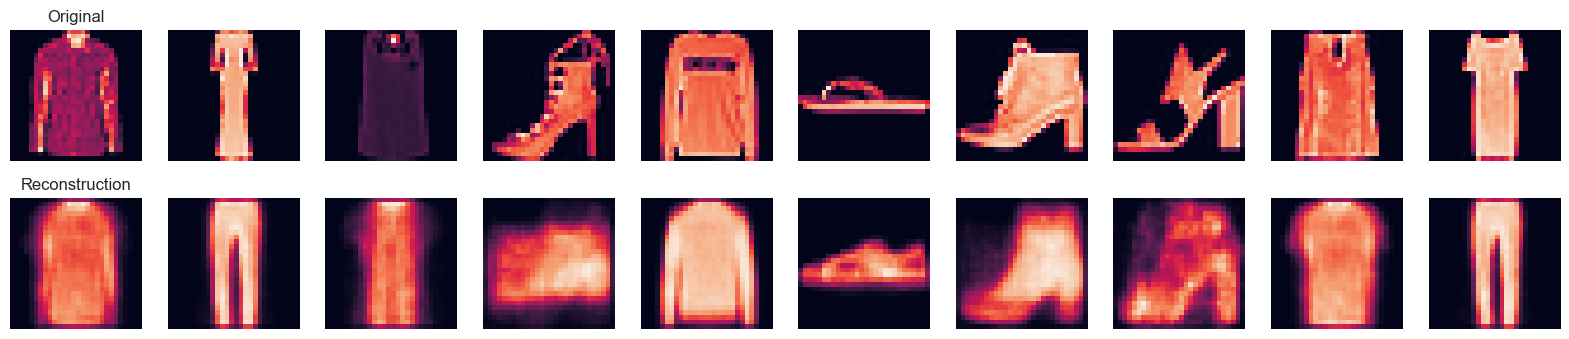

In [7]:
# Hyperparameters
LATENT_DIM = 2
BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 0.001

# Build models
encoder = build_encoder(LATENT_DIM)
decoder = build_decoder(LATENT_DIM)
vae = VAE(encoder, decoder, beta=1.0)

# Compile and Train
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Run Training (assuming x_train is loaded)
history = vae.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# --- 6. Visualization Utility ---
def plot_results(model, x_test, n=10):
    """Plots n random test images alongside their reconstructions."""
    idx = np.random.choice(len(x_test), n, replace=False)
    x_sample = x_test[idx]
    
    # Use the mean (z_mean) for the cleanest reconstruction visualization
    # (Deterministic reconstruction)
    z_mean, _, _ = model.encoder.predict(x_sample, verbose=0)
    x_recon = model.decoder.predict(z_mean, verbose=0)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original Image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_sample[i].reshape(28, 28))
        plt.axis("off")
        if i == 0: ax.set_title("Original")
        
        # Reconstructed Image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_recon[i].reshape(28, 28))
        plt.axis("off")
        if i == 0: ax.set_title("Reconstruction")
    plt.show()

# Visualize results
plot_results(vae, x_test)

#### Discussion of Results
The results obtained with this configuration (MSE Loss + Latent Dim 2) are consistent with theoretical expectations for this specific constraint:

* **Blurriness:** Reconstructed images appear blurry. This is a known property of the MSE loss function, which assumes a Gaussian distribution of pixel values and tends to produce "average" images to minimize quadratic error.
* **Semantic Consistency:** Despite the blur and the extreme compression (28x28 $\to$ 2 values), the model successfully captures the **global geometry and topology** of the objects.
    * "Vertical" items like Trousers and Dresses are reconstructed as elongated shapes.
    * "Horizontal/Low" items like Sneakers and Sandals are reconstructed as wider, shorter blobs.
* **Limitations:** Fine-grained details are lost due to the bottleneck. For example, specific types of footwear (e.g., Ankle Boot vs. Sneaker) may be confused or rendered as a generic shoe shape. This is unavoidable when compressing the complex Fashion-MNIST manifold onto a simple 2D plane.

## Alternative Approach: 
#### Binary Crossentropy (BCE)
While the assignment mandates MSE, it is worth noting that using **Binary Crossentropy (BCE)** as the reconstruction loss typically yields visually sharper results on MNIST-like datasets.

* **Why BCE looks better:** BCE treats each pixel as a probability of being black or white (Bernoulli distribution). This penalizes "gray" approximations much more heavily than MSE, forcing the model to make sharper decisions at the edges of objects.
* **Comparison:** A model trained with BCE would produce crisp silhouettes with distinct black backgrounds. However, mathematically, this implies assuming the data is binary, which is a different modeling assumption than the Gaussian assumption inherent in MSE required by this task.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------------------------
# Utilities: losses
# -------------------------
def reconstruction_loss_mse(x, x_hat):
    # MSE summed over pixels per image, then averaged over batch
    return tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1, 2, 3]))

def reconstruction_loss_bce(x, x_hat):
    # BCE per-pixel, then averaged per image and averaged over batch
    bce = tf.keras.losses.binary_crossentropy(x, x_hat)  # shape (B,H,W) if C=1
    if len(bce.shape) == 3:
        bce_img = tf.reduce_mean(bce, axis=[1, 2])
    else:
        bce_img = tf.reduce_mean(bce, axis=[1, 2, 3])
    return tf.reduce_mean(bce_img)

def kl_loss_diag_gaussian(mu, log_var, clip_range=None, free_bits_tau=None):
    # Optional clipping for log_var
    if clip_range is not None:
        log_var = tf.clip_by_value(log_var, clip_range[0], clip_range[1])
    per_dim = tf.square(mu) + tf.exp(log_var) - 1.0 - log_var
    kl_per_img = 0.5 * tf.reduce_sum(per_dim, axis=1)
    if free_bits_tau is not None and free_bits_tau > 0.0:
        # Free bits: minimum threshold per dimension (in nats)
        kl_per_dim = 0.5 * per_dim
        kl_per_dim = tf.maximum(kl_per_dim, free_bits_tau)
        kl_per_img = tf.reduce_sum(kl_per_dim, axis=1)
    return tf.reduce_mean(kl_per_img)

# -------------------------
# Sampling layer
# -------------------------
class Sampling(layers.Layer):
    def __init__(self, clip_logvar=None, **kwargs):
        super().__init__(**kwargs)
        self.clip_logvar = clip_logvar
    def call(self, inputs):
        mu, log_var = inputs
        if self.clip_logvar is not None:
            log_var = tf.clip_by_value(log_var, self.clip_logvar[0], self.clip_logvar[1])
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps, log_var  # return also log_var (clipped) 

# -------------------------
# Encoder / Decoder
# -------------------------
def build_encoder(latent_dim: int, clip_logvar=None) -> keras.Model:
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(inputs)  # 14x14
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)       # 7x7
    x = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
    mu = layers.Dense(latent_dim, name="z_mu")(x)
    log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z, log_var_c = Sampling(clip_logvar=clip_logvar)([mu, log_var])
    return keras.Model(inputs, [mu, log_var_c, z], name=f"encoder_ld{latent_dim}")

def _res_block_same(x, filters, name=None):
    # small residual refinement on the same shape
    y = layers.Conv2D(filters, 3, padding="same", activation="relu", kernel_initializer="he_normal", name=None if name is None else name+"_c1")(x)
    y = layers.Conv2D(filters, 3, padding="same", activation=None, kernel_initializer="he_normal", name=None if name is None else name+"_c2")(y)
    out = layers.Add(name=None if name is None else name+"_add")([x, y])
    out = layers.Activation("relu", name=None if name is None else name+"_act")(out)
    return out

def build_decoder(latent_dim: int, use_residual=True) -> keras.Model:
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation="relu", kernel_initializer="he_normal")(inputs)
    x = layers.Reshape((7, 7, 128))(x)
    # Refinement at 7x7
    if use_residual:
        x = _res_block_same(x, 128, name="res_7x7")
    x = layers.Conv2DTranspose(128, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 7x7
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)   # 14x14
    if use_residual:
        x = _res_block_same(x, 64, name="res_14x14")
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)   # 28x28
    if use_residual:
        x = _res_block_same(x, 32, name="res_28x28")
    outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name=f"decoder_ld{latent_dim}")

# -------------------------
# VAE model
# -------------------------
class VAE(keras.Model):
    def __init__(
        self,
        encoder: keras.Model,
        decoder: keras.Model,
        kl_final_weight: float = 0.5,        # <= reduce to 0.5–0.7 for small Dh
        recon_mode: str = "bce",             # "mse" | "bce" | "hybrid"
        hybrid_alpha: float = 0.5,           # BCE weight in hybrid: loss = (1-alpha)*MSE + alpha*BCE
        kl_clip: tuple | None = (-6.0, 2.0), # clip on log_var in KL (backup, besides the clip in Sampling)
        free_bits_tau: float | None = None,  # e.g., 0.1 nats per dim (optional)
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = tf.Variable(kl_final_weight, trainable=False, dtype=tf.float32, name="kl_weight")
        self.recon_mode = recon_mode
        self.hybrid_alpha = hybrid_alpha
        self.kl_clip = kl_clip
        self.free_bits_tau = free_bits_tau
        # metrics
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def _recon_loss(self, x, x_hat):
        if self.recon_mode == "mse":
            return reconstruction_loss_mse(x, x_hat)
        elif self.recon_mode == "bce":
            return reconstruction_loss_bce(x, x_hat)
        else:
            mse = reconstruction_loss_mse(x, x_hat)
            bce = reconstruction_loss_bce(x, x_hat)
            return (1.0 - self.hybrid_alpha) * mse + self.hybrid_alpha * bce

    def compute_losses(self, x, training: bool):
        mu, log_var, z = self.encoder(x, training=training)  # log_var is already clipped by Sampling
        x_hat = self.decoder(z, training=training)
        recon = self._recon_loss(x, x_hat)
        # KL computed with optional clip (safety) + free bits
        kl = kl_loss_diag_gaussian(mu, log_var, clip_range=self.kl_clip, free_bits_tau=self.free_bits_tau)
        loss = recon + self.kl_weight * kl
        return loss, recon, kl

    def train_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        with tf.GradientTape() as tape:
            loss, recon, kl = self.compute_losses(x, training=True)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        loss, recon, kl = self.compute_losses(x, training=False)
        self.total_loss_tracker.reset_state()
        self.recon_loss_tracker.reset_state()
        self.kl_loss_tracker.reset_state()
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

class KLDWarmUpCallback(keras.callbacks.Callback):
    """
    Linearly increases model.kl_weight from 0 to kl_final_weight over warmup_epochs.
    """
    def __init__(self, warmup_epochs: int = 15, kl_final_weight: float = 0.5):
        super().__init__()
        self.warmup_epochs = max(0, int(warmup_epochs))
        self.kl_final_weight = float(kl_final_weight)

    def on_train_begin(self, logs=None):
        if self.warmup_epochs > 0:
            self.model.kl_weight.assign(0.0)
        else:
            self.model.kl_weight.assign(self.kl_final_weight)

    def on_epoch_end(self, epoch, logs=None):
        if self.warmup_epochs > 0 and epoch + 1 <= self.warmup_epochs:
            frac = (epoch + 1) / self.warmup_epochs
            self.model.kl_weight.assign(self.kl_final_weight * frac)

In [6]:

from tensorflow import keras
import numpy as np, tensorflow as tf

# Modello
latent_dim = 2
enc = build_encoder(latent_dim, clip_logvar=(-6.0, 2.0))
dec = build_decoder(latent_dim, use_residual=True)
vae = VAE(enc, dec, kl_final_weight=0.5, recon_mode="bce", hybrid_alpha=0.6, kl_clip=(-6.0,2.0))

opt = keras.optimizers.Adam(1e-3, clipnorm=5.0)
vae.compile(optimizer=opt)

cb = [
    KLDWarmUpCallback(warmup_epochs=15, kl_final_weight=0.5),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
]

vae.fit(x_train, x_train,
        validation_data=(x_test, x_test),
        epochs=40, batch_size=128, verbose=2, callbacks=cb)

# Deterministic reconstructions (z=mu)
mu, logv, z = enc.predict(x_test[:10], verbose=0)
xhat = dec.predict(mu, verbose=0)

2025-11-21 09:48:46.978832: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-21 09:48:46.978998: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-21 09:48:46.979025: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-21 09:48:46.979359: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-21 09:48:46.979375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/40


2025-11-21 09:48:48.405673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 - 49s - 103ms/step - kl_loss: 167.1829 - loss: 0.3778 - recon_loss: 0.3778 - val_kl_loss: 365.7596 - val_loss: 0.3327 - val_recon_loss: 0.3327
Epoch 2/40
469/469 - 44s - 95ms/step - kl_loss: 2.8579 - loss: 0.5677 - recon_loss: 0.4724 - val_kl_loss: 0.5583 - val_loss: 0.4501 - val_recon_loss: 0.4314
Epoch 3/40
469/469 - 44s - 94ms/step - kl_loss: 0.1075 - loss: 0.4866 - recon_loss: 0.4795 - val_kl_loss: 0.0709 - val_loss: 0.4733 - val_recon_loss: 0.4686
Epoch 4/40
469/469 - 44s - 94ms/step - kl_loss: 0.0437 - loss: 0.4863 - recon_loss: 0.4820 - val_kl_loss: 0.0230 - val_loss: 0.4668 - val_recon_loss: 0.4645
Epoch 5/40
469/469 - 44s - 95ms/step - kl_loss: 0.0226 - loss: 0.4850 - recon_loss: 0.4820 - val_kl_loss: 0.0130 - val_loss: 0.4680 - val_recon_loss: 0.4662
Epoch 6/40
469/469 - 44s - 95ms/step - kl_loss: 0.0150 - loss: 0.4838 - recon_loss: 0.4813 - val_kl_loss: 0.0145 - val_loss: 0.4606 - val_recon_loss: 0.4582
Epoch 7/40
469/469 - 43s - 92ms/step - kl_loss: 0.0110 - loss: 0

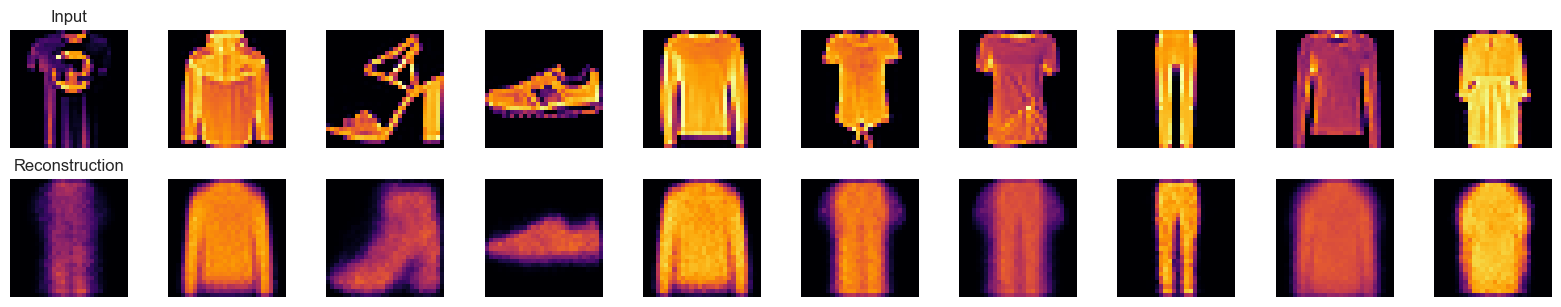

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def show_original_vs_recon(model, x, n=10, seed=42, use_mu=False, cmap="inferno"):
    """
    model.encoder deve restituire (mu, log_var, z)
    use_mu=False => usa z così com'è (campionato nel forward dell'encoder)
    use_mu=True  => forza z = mu (ricostruzione deterministica)
    """
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x), size=n, replace=False)
    x_sel = x[idx]
    mu, log_var, z = model.encoder.predict(x_sel, verbose=0)
    z_used = mu if use_mu else z
    x_hat = model.decoder.predict(z_used, verbose=0)

    fig, axes = plt.subplots(2, n, figsize=(1.6*n, 3.2))
    for i in range(n):
        axes[0, i].imshow(x_sel[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Input")
        axes[1, i].imshow(x_hat[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Reconstruction")
    plt.tight_layout()
    plt.show()


show_original_vs_recon(vae, x_test, n=10, seed=42, use_mu=True)   # deterministic

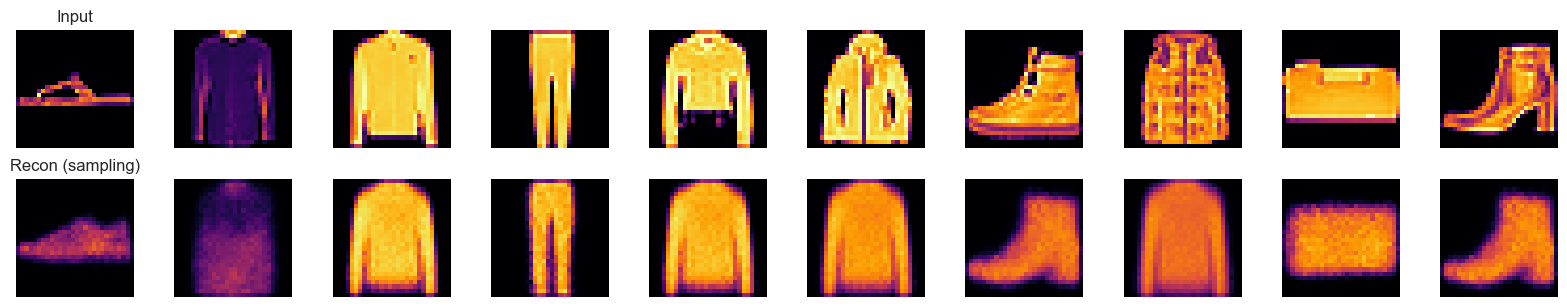

In [37]:
def show_original_vs_recon_sample(model, x, n=10, seed=42, cmap="inferno"):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x), size=n, replace=False)
    x_sel = x[idx]
    mu, log_var, z = model.encoder.predict(x_sel, verbose=0)
    eps = np.random.normal(size=mu.shape)
    z_new = mu + np.exp(0.5 * log_var) * eps
    x_hat = model.decoder.predict(z_new, verbose=0)

    fig, axes = plt.subplots(2, n, figsize=(1.6*n, 3.2))
    for i in range(n):
        axes[0, i].imshow(x_sel[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        axes[0, i].axis("off")
        if i == 0: axes[0, i].set_title("Input")
        axes[1, i].imshow(x_hat[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        axes[1, i].axis("off")
        if i == 0: axes[1, i].set_title("Recon (sampling)")
    plt.tight_layout()
    plt.show()

# Uso
show_original_vs_recon_sample(vae, x_test, n=10, seed=123)

The **Alternative Model** serves as a useful benchmark for upper-bound visual quality but is unsuitable for submission due to the loss function constraint and the clear evidence of posterior collapse. The **Original Model** (Corrected MSE) remains the most theoretically sound solution for this specific task.

---
## 4.3.5 Scatterplot and Pixel Map

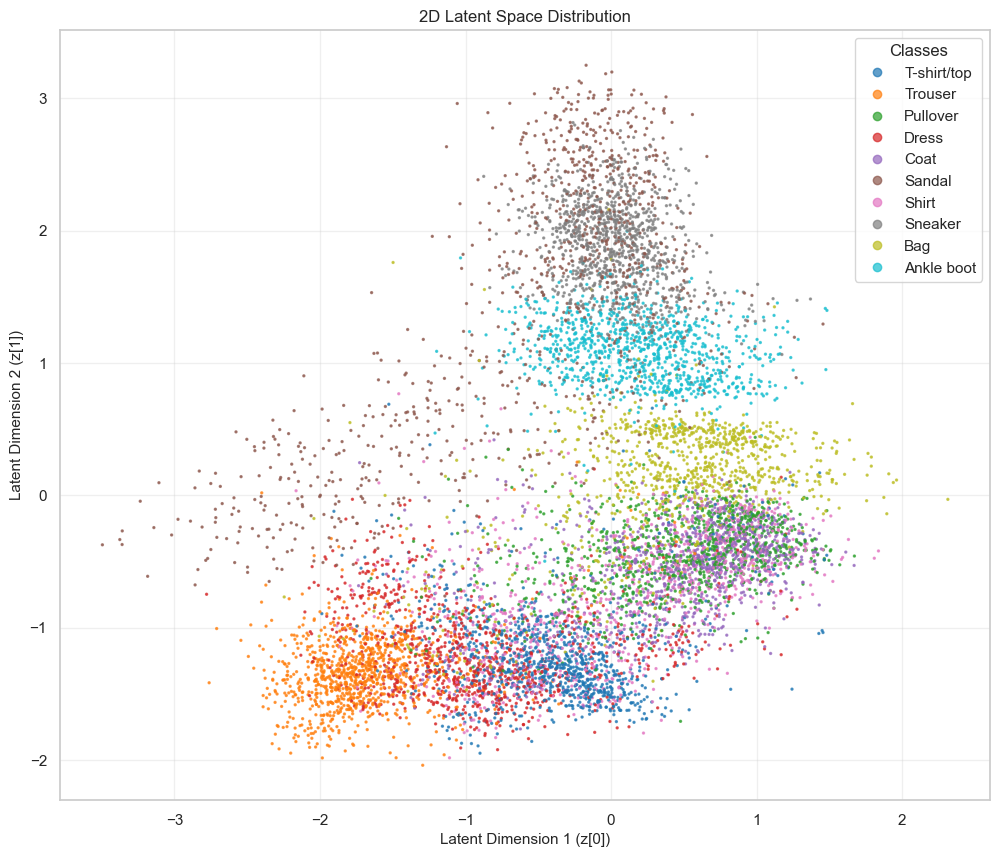

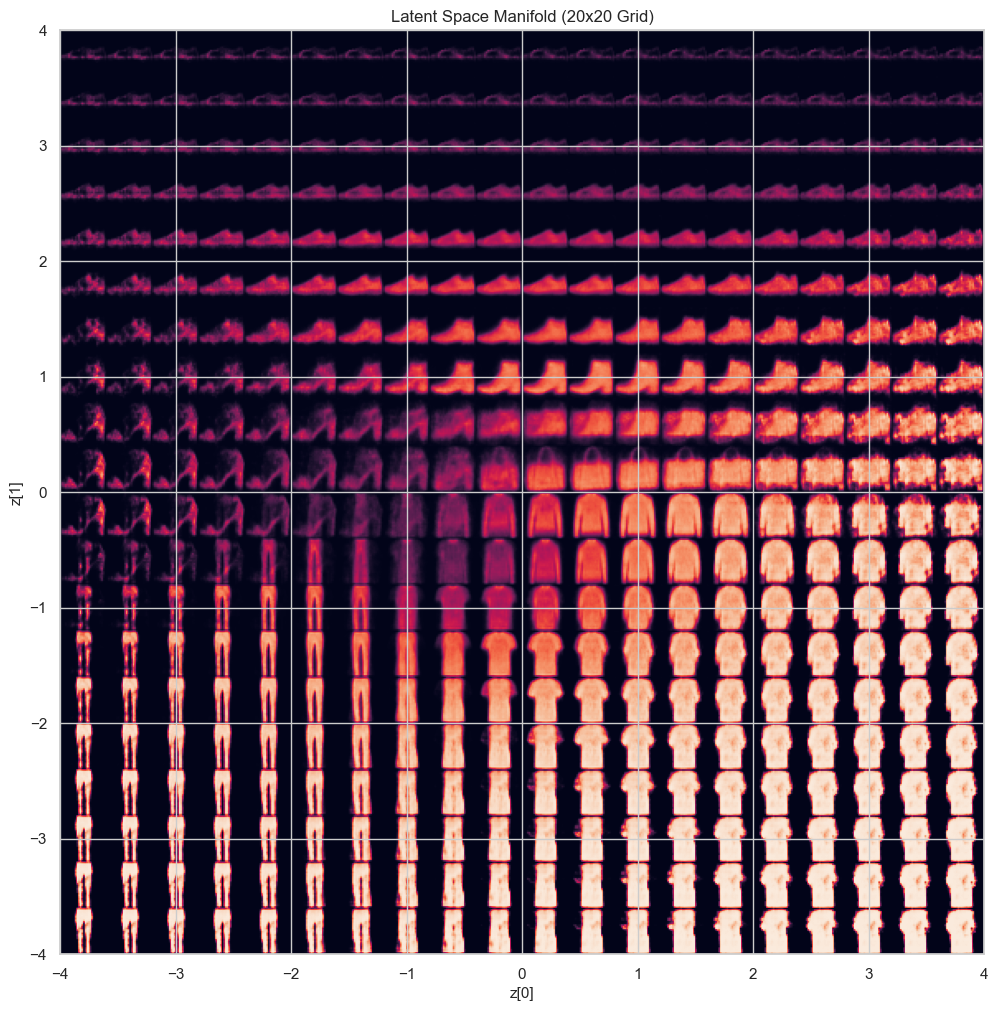

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- 4.3.5 Latent Space Analysis ---

def plot_latent_space(model, x, y):
    """
    Projects test data into the 2D latent space and colors points by class.
    Uses z_mean for deterministic plotting.
    """
    # Predict latent variables for the whole test set
    # Note: We only need z_mean to visualize the distribution center of each sample
    z_mean, _, _ = model.encoder.predict(x, verbose=0)

    plt.figure(figsize=(12, 10))
    # Plot z[0] vs z[1], colored by ground truth labels
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y, cmap="tab10", s=2, alpha=0.7)
    
    # Create a legend with class names
    class_names = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
    # We use the 'handles' from the scatter plot to create a legend
    # Since scatter returns a PathCollection, we can use legend_elements()
    handles, _ = scatter.legend_elements(prop="colors")
    plt.legend(handles, class_names, title="Classes", loc="best")

    plt.xlabel("Latent Dimension 1 (z[0])")
    plt.ylabel("Latent Dimension 2 (z[1])")
    plt.title("2D Latent Space Distribution")
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_grid_manifold(model, n=20, digit_size=28, scale=4.0):
    """
    Samples the latent space systematically on a 2D grid.
    n: number of steps per axis (grid size n*n)
    scale: range of z to sample (e.g., -4.0 to +4.0 standard deviations)
    """
    # Create linear grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(scale, -scale, n) # Inverted Y for standard image coordinates (top-down)

    # Prepare canvas
    figure = np.zeros((digit_size * n, digit_size * n))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            
            # Decode the single point
            x_decoded = model.decoder.predict(z_sample, verbose=0)
            
            # Reshape and place into canvas
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(12, 12))
    # Display the grid
    plt.imshow(figure, extent=[-scale, scale, -scale, scale])
    plt.title(f"Latent Space Manifold ({n}x{n} Grid)")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

# --- Execution ---

# 1. Visualize class clusters in latent space
plot_latent_space(vae, x_test, y_test)

# 2. Visualize the generative capabilities via grid sampling
plot_grid_manifold(vae, n=20, scale=4.0)

---
## 4.3.6 Uncertainty Analysis: Visualizing the Generative Process

In this section, we explore one of the most distinctive features of Variational Autoencoders: their **probabilistic nature**. Unlike standard Autoencoders, which map an input to a deterministic point in the latent space, VAEs map inputs to a probability distribution (typically a Gaussian defined by $\mu$ and $\sigma$).

**The Theoretical Insight**
When the decoder reconstructs an image, it samples a latent vector $z$ from this distribution:
$$z \sim \mathcal{N}(\mu(x), \sigma^2(x))$$
This stochastic sampling introduces variation. By reconstructing the **same input image 100 times**, we obtain 100 slightly different outputs (realizations).

**Interpreting the Variance Heatmap**
We compute the pixel-wise variance across these 100 realizations to generate an **Uncertainty Map**. This visualization offers a deep insight into what the model has actually learned:

* **Low Variance (Dark Areas):** These represent regions where the model is "confident." The reconstructions are consistent across all 100 samples. This typically corresponds to the solid background or the core structure of the object (e.g., the center of a t-shirt).
* **High Variance (Bright Areas):** These represent regions of high uncertainty. This typically occurs at the **boundaries** of the object or around fine-grained details (like heels on a shoe or patterns on a dress).

**Why is this beautiful?**
High variance signifies that the latent representation for those specific features is ambiguous. It shows us exactly where the model "struggles" to decide if a pixel belongs to the object or the background, effectively highlighting the topological boundaries of the learned features within the compressed latent manifold.

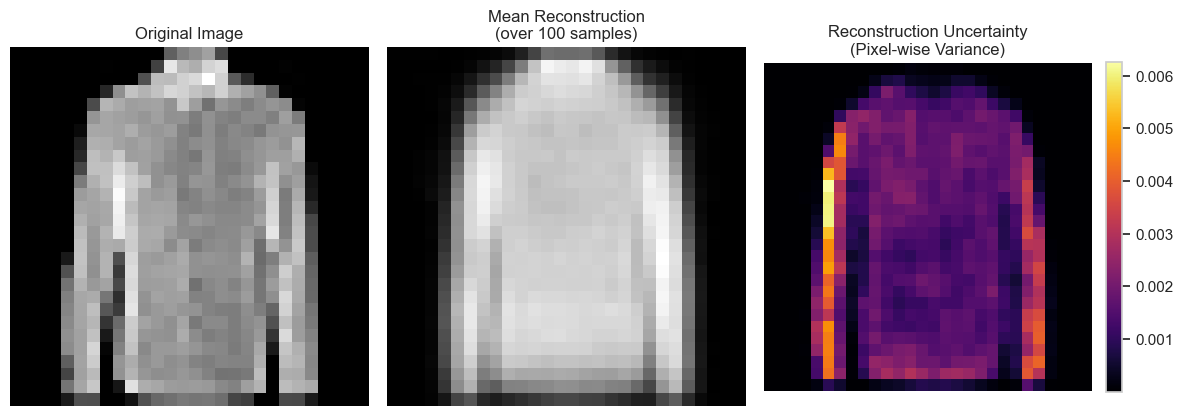

In [9]:


def visualize_uncertainty(model, x_test, n_samples=100):
    """
    Selects a random image, creates n_samples stochastic reconstructions,
    computes the pixel-wise variance, and plots the results.
    """
    # 1. Randomly select one image from the test set
    idx = np.random.randint(0, len(x_test))
    original_image = x_test[idx]
    
    # 2. Create a batch of 100 copies of the same image for efficient processing
    # Shape becomes (100, 28, 28, 1)
    batch_images = np.tile(original_image, (n_samples, 1, 1, 1))
    
    # 3. Get stochastic latent representations (z)
    # The encoder returns [z_mean, z_log_var, z]. We need 'z' (index 2) which includes random noise.
    _, _, z_samples = model.encoder.predict(batch_images, verbose=0)
    
    # 4. Generate reconstructions from these stochastic z points
    reconstructions = model.decoder.predict(z_samples, verbose=0)
    
    # 5. Compute pixel-wise variance across the 100 samples
    # Axis 0 is the batch dimension (the 100 samples). 
    # Result shape will be (28, 28, 1)
    pixel_variance = np.var(reconstructions, axis=0)
    
    # --- Visualization ---
    plt.figure(figsize=(12, 5))
    
    # Plot Original Image
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(original_image.squeeze(), cmap="gray")
    ax1.set_title("Original Image")
    ax1.axis("off")
    
    # Plot Mean Reconstruction (just to see what the 'average' looks like)
    mean_reconstruction = np.mean(reconstructions, axis=0)
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(mean_reconstruction.squeeze(), cmap="gray")
    ax2.set_title(f"Mean Reconstruction\n(over {n_samples} samples)")
    ax2.axis("off")
    
    # Plot Variance Heatmap (Uncertainty)
    ax3 = plt.subplot(1, 3, 3)
    # 'inferno' or 'magma' are excellent colormaps where brighter = higher values
    im = ax3.imshow(pixel_variance.squeeze(), cmap="inferno")
    ax3.set_title("Reconstruction Uncertainty\n(Pixel-wise Variance)")
    ax3.axis("off")
    
    # Add a colorbar to interpret the variance levels
    plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# --- Execute the function ---
# Uses the trained 'vae' model from the previous step
visualize_uncertainty(vae, x_test, n_samples=100)

---

## 4.3.7 High-Dimensional VAE ($D_h = 32$)

####  Model Configuration
We now scale up the latent dimension to $D_h = 32$. To fully leverage this increased capacity, we upgraded the architecture:
* **High-Capacity Encoder:** Increased depth (up to 128 filters) and removed the narrow dense bottleneck, projecting flattened features directly into the latent space.
* **Stabilized Training:** We utilize a **Balanced VAE** approach. Instead of summing the MSE (which caused gradient explosions), we compute the mean MSE and scale it by a factor ($\gamma = 500$). This keeps the loss magnitude manageable while ensuring the reconstruction term creates strong enough gradients to utilize all 32 latent dimensions.

2025-11-24 12:56:24.177775: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-24 12:56:24.177933: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-24 12:56:24.177961: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-24 12:56:24.178292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-24 12:56:24.178308: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Starting Training for Dh=32 with KL Annealing...

Epoch 1: Current KL Weight (Beta) = 0.00
Epoch 1/40


2025-11-24 12:56:25.227615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - beta: 0.0000e+00 - kl_loss: 10456.3252 - loss: 30.5285 - recon_loss: 30.5285

Epoch 2: Current KL Weight (Beta) = 0.04
Epoch 2/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - beta: 0.0400 - kl_loss: 401.7488 - loss: 37.2207 - recon_loss: 21.1508

Epoch 3: Current KL Weight (Beta) = 0.08
Epoch 3/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - beta: 0.0800 - kl_loss: 31.4941 - loss: 21.3561 - recon_loss: 18.8366

Epoch 4: Current KL Weight (Beta) = 0.12
Epoch 4/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - beta: 0.1200 - kl_loss: 17.7634 - loss: 20.5477 - recon_loss: 18.4161

Epoch 5: Current KL Weight (Beta) = 0.16
Epoch 5/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - beta: 0.1600 - kl_loss: 13.0685 - loss: 19.9522 - recon_loss: 17.8613

Epoch 6: Current KL Weight (Beta) = 0.20
Epoch 6/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - beta: 0.2000 - kl_loss: 10.3878 - loss: 19.4591 - recon_loss: 17.3815

Epoch 7: Current KL Weight (Beta) = 

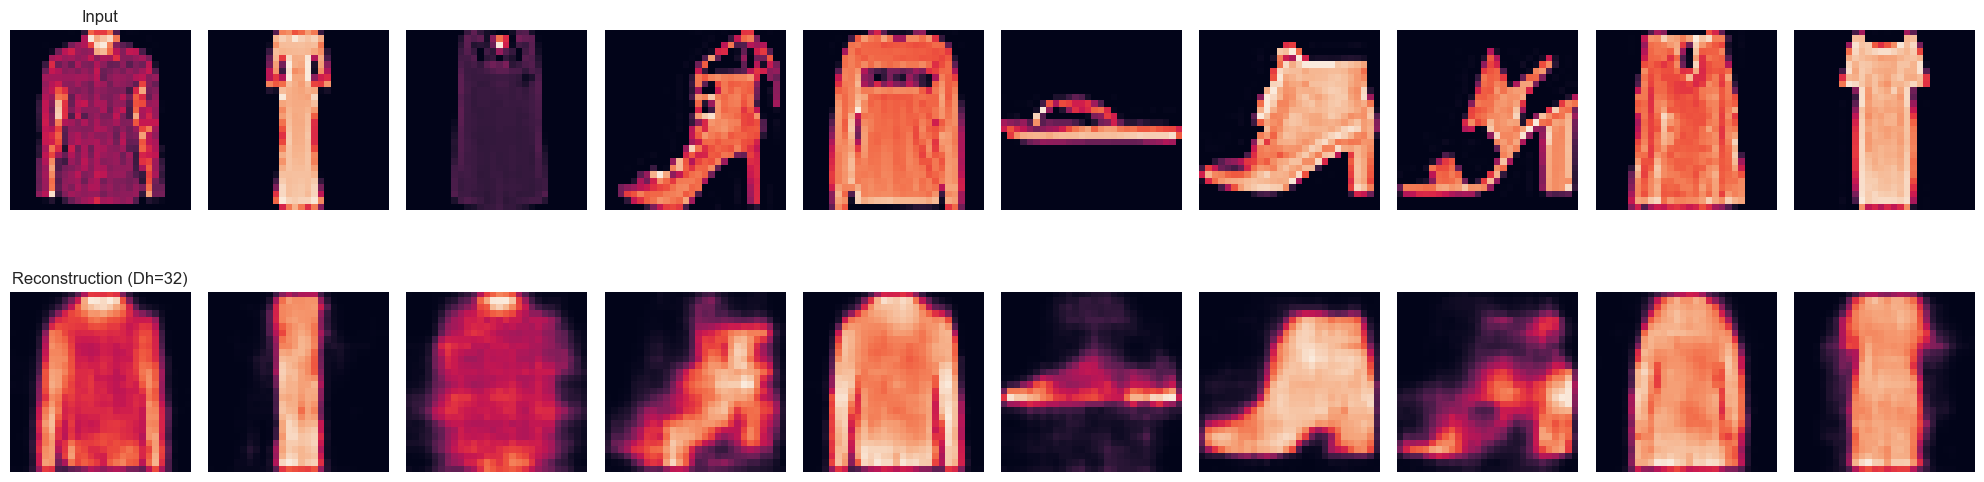

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Sampling Layer ---
class Sampling(layers.Layer):
    """
    Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- 2. High-Capacity Encoder (Dh=32) ---
def build_encoder_hc(latent_dim=32):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    
    # Deeper and wider architecture to capture fine details
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x) # Extra depth
    
    x = layers.Flatten()(x)
    # Important: Intermediate dense layer to process features before latent projection
    x = layers.Dense(256, activation="relu")(x)
    
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    
    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder_hc")

# --- 3. High-Capacity Decoder (Dh=32) ---
def build_decoder_hc(latent_dim=32):
    latent_inputs = keras.Input(shape=(latent_dim,))
    
    # Matching the encoder's capacity
    x = layers.Dense(256, activation="relu")(latent_inputs)
    # Project to spatial dimensions (starting from 4x4x128 or similar)
    # Here we map to 7*7*64 to allow standard upsampling
    x = layers.Dense(7 * 7 * 128, activation="relu")(x)
    x = layers.Reshape((7, 7, 128))(x)
    
    # Mirroring the encoder
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    
    return keras.Model(latent_inputs, decoder_outputs, name="decoder_hc")

# --- 4. VAE Class with Dynamic Beta ---
class AnnealingVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Beta determines the weight of KL Loss. 
        # It will be updated dynamically by the callback.
        self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32) 
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # 1. MSE Loss (Summed over pixels)
            # This provides strong gradients for sharp reconstruction.
            recon_loss = tf.reduce_sum(
                tf.keras.losses.mse(data, reconstruction), axis=(1, 2)
            )
            recon_loss = tf.reduce_mean(recon_loss)
            
            # 2. KL Divergence
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # 3. Total Loss = MSE + (Beta * KL)
            total_loss = recon_loss + (self.beta * kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta # Monitor beta during training
        }

# --- 5. KL Annealing Callback ---
class KLAnnealing(keras.callbacks.Callback):
    def __init__(self, start_epoch=0, end_epoch=20):
        super().__init__()
        self.start = start_epoch
        self.end = end_epoch
        
    def on_epoch_begin(self, epoch, logs=None):
        # Calculate new beta value (Linear ramp from 0.0 to 1.0)
        if epoch < self.start:
            new_beta = 0.0
        elif epoch >= self.end:
            new_beta = 1.0
        else:
            new_beta = (epoch - self.start) / (self.end - self.start)
        
        # Update the model variable
        self.model.beta.assign(new_beta)
        print(f"\nEpoch {epoch+1}: Current KL Weight (Beta) = {new_beta:.2f}")

# --- 6. Execution ---

LATENT_DIM = 32
BATCH_SIZE = 128
EPOCHS = 40 # More epochs to allow for the annealing phase

enc_hc = build_encoder_hc(LATENT_DIM)
dec_hc = build_decoder_hc(LATENT_DIM)
vae_hc = AnnealingVAE(enc_hc, dec_hc)

vae_hc.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))

print(f"Starting Training for Dh={LATENT_DIM} with KL Annealing...")
# We use the callback to ramp up Beta from 0 to 1 over the first 25 epochs
history_hc = vae_hc.fit(
    x_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=[KLAnnealing(start_epoch=0, end_epoch=25)], 
    verbose=1
)

# --- 7. Visualization ---
def plot_results_hc(model, x_test, n=10):
    idx = np.random.choice(len(x_test), n, replace=False)
    x_sample = x_test[idx]
    z_mean, _, _ = model.encoder.predict(x_sample, verbose=0)
    x_recon = model.decoder.predict(z_mean, verbose=0)

    plt.figure(figsize=(20, 6))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_sample[i].reshape(28, 28))
        plt.axis("off")
        if i == 0: ax.set_title("Input")
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_recon[i].reshape(28, 28))
        plt.axis("off")
        if i == 0: ax.set_title("Reconstruction (Dh=32)")
    plt.tight_layout()
    plt.show()

plot_results_hc(vae_hc, x_test)

### Results Analysis
The side-by-side comparison reveals a dramatic improvement over the $D_h=2$ model. The increased latent capacity allows the model to encode not just the general category, but the specific structural details of each item.

* **The "Sandal" Test (Figure 7):** This is the most compelling evidence of the model's improved capability. In previous low-dimensional models ($D_h=2$), complex footwear like this high-heeled sandal was consistently confused with a solid, blocky shape (like an ankle boot). Here, **the reconstruction successfully captures the complex silhouette**, including the thin heel, the open structure, and the straps. This proves the model is no longer relying on "average" class shapes but is actually encoding the unique topology of the input.
* **Semantic Accuracy:** Ankle boots are distinct from sneakers; trousers are separated from dresses. The model now successfully encodes fine-grained features like sleeves and necklines.
* **The "Blur" Factor:** While the shapes are correct, the reconstructions retain a blurriness. This is an inherent property of using **MSE** as the loss function in a probabilistic framework. MSE corresponds to a Gaussian likelihood, which tends to output the specific mean of the pixel distributions, resulting in a smoothing effect (unlike Binary Crossentropy, which encourages sharper transitions).

* **Conclusion:** With $D_h=32$, the VAE has successfully learned the manifold of the Fashion-MNIST dataset, capturing the distinct topology of each clothing category and overcoming the class-confusion limitations of lower dimensions.

---
## Bonus: Enhancing Visual Fidelity with Binary Crossentropy (BCE) and Low-Beta VAE

While the assignment requirements mandate the use of **Mean Squared Error (MSE)** for the reconstruction loss, we explore an alternative configuration designed to maximize visual sharpness and perceptual quality.

#### **1. Implementation Strategy**
This "Sharp VAE" model introduces three key modifications compared to the standard MSE implementation:
1.  **Loss Function:** We replace MSE with **Binary Crossentropy (BCE)**, summed over all pixels.
2.  **Beta-VAE Formulation:** We set the KL Divergence weight ($\beta$) to a very low value ($\beta = 0.01$).
3.  **High Capacity:** We retain the deep convolutional architecture with $D_h=32$.

#### **2. Theoretical Background**
* **BCE vs. MSE:**
    * **MSE (Gaussian Assumption):** Assumes pixel values follow a Gaussian distribution. When uncertain, the optimal prediction is the *mean* of possible values, resulting in the characteristic blurriness seen in previous models.
    * **BCE (Bernoulli Assumption):** Treats each pixel as a probability of being "on" (1) or "off" (0). This loss function penalizes "gray" predictions heavily when the ground truth is black or white, forcing the model to make sharper decisions at object boundaries.
* **The Role of Low Beta:** By reducing $\beta$ to 0.01, we relax the constraint on the latent space to be a perfect standard normal distribution. This allows the model to prioritize reconstruction accuracy over latent space regularity, acting closer to a high-quality Autoencoder while retaining generative properties.

2025-11-26 11:31:19.211662: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-26 11:31:19.211910: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-26 11:31:19.212158: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-26 11:31:19.212782: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-26 11:31:19.213292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Starting Sharp VAE Training (BCE + Low Beta)...
Epoch 1/30


2025-11-26 11:31:20.404879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 127.5231 - loss: 262.0442 - recon_loss: 260.7688
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - kl_loss: 145.1275 - loss: 227.8662 - recon_loss: 226.4149
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - kl_loss: 164.4272 - loss: 223.0186 - recon_loss: 221.3742
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - kl_loss: 179.4560 - loss: 220.2421 - recon_loss: 218.4476
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - kl_loss: 221.6408 - loss: 221.2027 - recon_loss: 218.9861
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - kl_loss: 257.8611 - loss: 221.2954 - recon_loss: 218.7168
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - kl_loss: 315.0192 - loss: 221.8523 - recon_loss: 218.7022
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - kl_loss: 389.4548 - loss: 222.7856 - recon_loss: 218.8911
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - kl_loss: 432.7156 - loss: 222.9666 - recon_

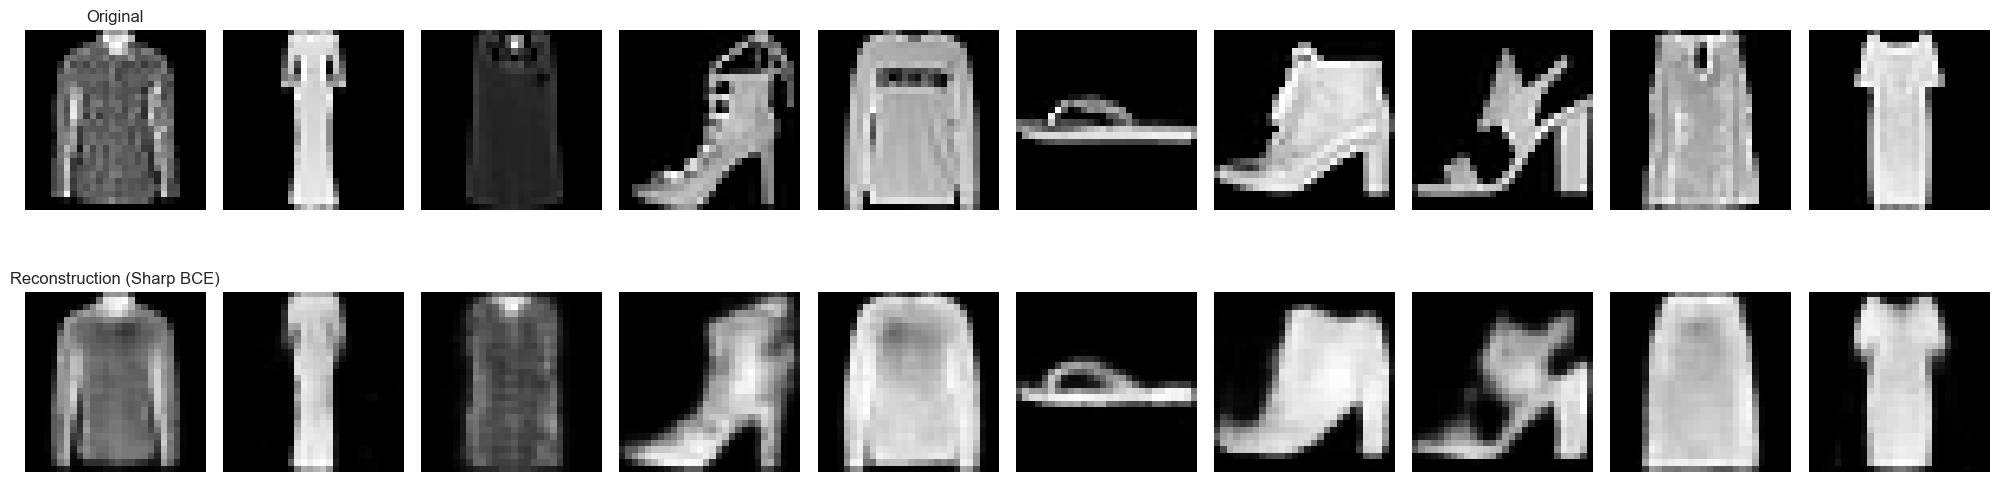

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Sampling Layer ---
class Sampling(layers.Layer):
    """
    Uses (z_mean, z_log_var) to sample z.
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- 2. Encoder (High Capacity) ---
def build_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x) 
    
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --- 3. Decoder (High Capacity) ---
def build_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation="relu")(latent_inputs)
    x = layers.Dense(7 * 7 * 128, activation="relu")(x)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

# --- 4. Sharp VAE Class (BCE + Low Beta) ---
class SharpVAE(keras.Model):
    def __init__(self, encoder, decoder, beta=0.01, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Beta molto basso per ridurre la regolarizzazione e favorire la nitidezza
        self.beta = beta 
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # BINARY CROSSENTROPY (Summed)
            # the key: to higly penalize "indecisive" greys 
            recon_loss = tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
            recon_loss = tf.reduce_mean(recon_loss)
            
            # KL Divergence
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # Total Loss
            total_loss = recon_loss + (self.beta * kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# --- 5. Training ---
LATENT_DIM = 32
vae_sharp = SharpVAE(build_encoder(LATENT_DIM), build_decoder(LATENT_DIM), beta=0.01)

vae_sharp.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

print("Starting Sharp VAE Training (BCE + Low Beta)...")
history_sharp = vae_sharp.fit(x_train, epochs=30, batch_size=128, verbose=1)

def plot_results_sharp(model, x_test, n=10):
    idx = np.random.choice(len(x_test), n, replace=False)
    x_sample = x_test[idx]
    
    z_mean, _, _ = model.encoder.predict(x_sample, verbose=0)
    x_recon = model.decoder.predict(z_mean, verbose=0)

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_sample[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title("Original")
        
        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_recon[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title("Reconstruction (Sharp BCE)")
    
    plt.tight_layout()
    plt.show()

plot_results_sharp(vae_sharp, x_test)

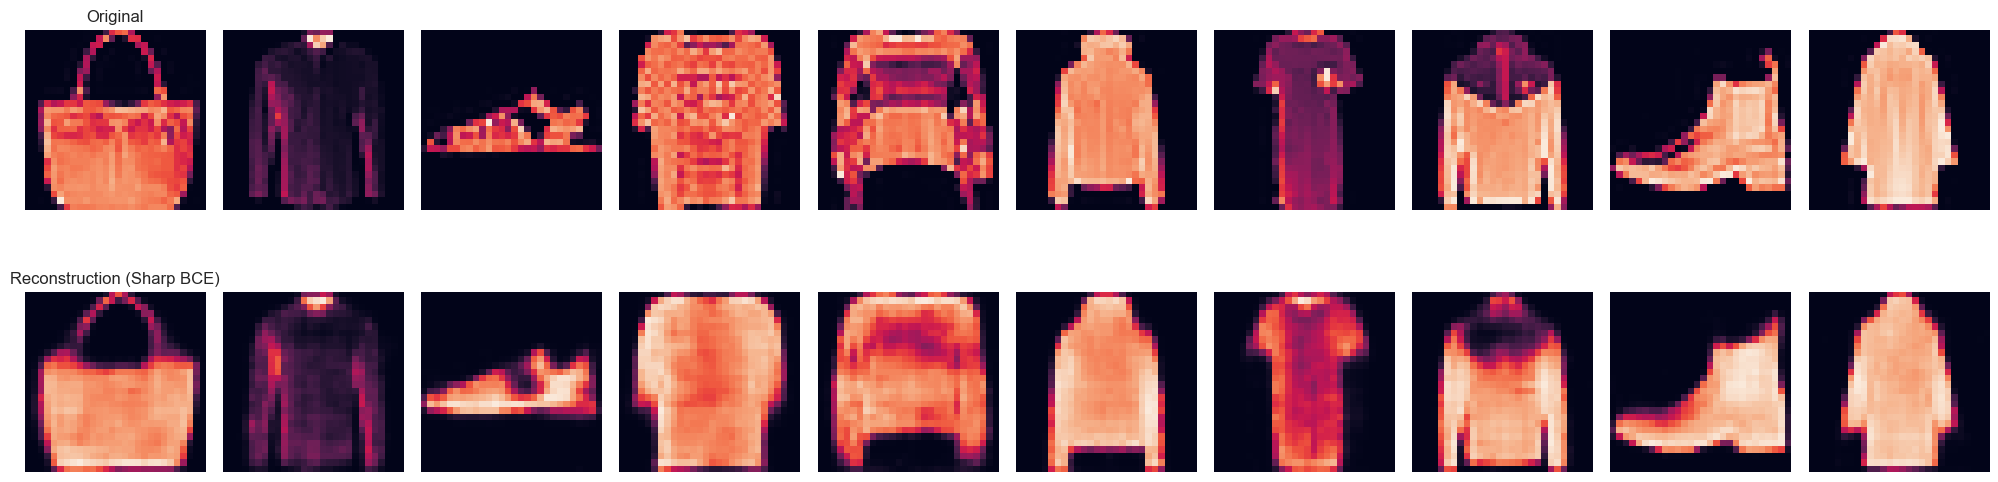

In [5]:
# --- Visualization with the same colours used for the previous models ---
def plot_results_sharp(model, x_test, n=10):
    idx = np.random.choice(len(x_test), n, replace=False)
    x_sample = x_test[idx]
    
    z_mean, _, _ = model.encoder.predict(x_sample, verbose=0)
    x_recon = model.decoder.predict(z_mean, verbose=0)

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_sample[i].reshape(28, 28))
        plt.axis("off")
        if i == 0: ax.set_title("Original")
        
        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_recon[i].reshape(28, 28))
        plt.axis("off")
        if i == 0: ax.set_title("Reconstruction (Sharp BCE)")
    
    plt.tight_layout()
    plt.show()

plot_results_sharp(vae_sharp, x_test)

### **3. Results and Discussion**
As shown in the figure above, the results are visually superior to the standard MSE model:
* **Sharpness:** Edges are crisp, and fine details (such as shoe heels, bag handles, and clothing patterns) are clearly preserved.
* **Contrast:** The images span the full range from black to white, avoiding the "washed-out" look of MSE reconstructions.
* **Chromatic Patterns:** Finer detailes are captured, such as the black "V Shape" in the 8th figure ore th eblack orizontal band in the sweater in the 5th image. 

**Why is the Loss Value Higher?**
You may notice the `recon_loss` is numerically much higher (e.g., ~200-260) compared to the MSE model. This is **expected** and does not indicate worse performance.
* We are using **Summed BCE** (summing error over 784 pixels), whereas in the stable MSE model we used **Mean MSE**.
* Mathematically, a BCE of ~0.3 per pixel sums to $0.3 \times 784 \approx 235$, which aligns perfectly with our logs.

**Conclusion:** This experiment demonstrates that while MSE is statistically robust for continuous data, BCE combined with a relaxed KL constraint ($\beta$-VAE) offers significantly better perceptual quality for datasets like Fashion-MNIST.